# Dependencies and data loading

In [1]:
# %pip install "accelerate>=0.26.0"

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)
from transformers import ViTForImageClassification
import accelerate
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Add project root to path
sys.path.append('..')

# Data paths
DATA_DIR = '../../data/processed'

c:\Users\sndp_\anaconda3\envs\deep-learning-sem4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Define paths
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load and label the training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Load and label the validation dataset
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 125 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [4]:
images, labels = next(train_generator)
print(images.shape)

(32, 150, 150, 3)


# Preprocessing

In [5]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [6]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [7]:
# Apply transforms to the train and validation datasets
def apply_transforms(generator, transform_fn):
	transformed_images = []
	transformed_labels = []
	for images, labels in generator:
		for i in range(len(images)):
			image = Image.fromarray((images[i] * 255).astype('uint8'))  # Convert to PIL Image
			transformed_image = transform_fn({'image': [image]})['pixel_values'][0]
			transformed_images.append(transformed_image)
			transformed_labels.append(labels[i])
		break  # Remove this line if you want to process the entire dataset
	return np.stack(transformed_images), np.array(transformed_labels)

train_images, train_labels = apply_transforms(train_generator, train_transforms)
val_images, val_labels = apply_transforms(val_generator, val_transforms)

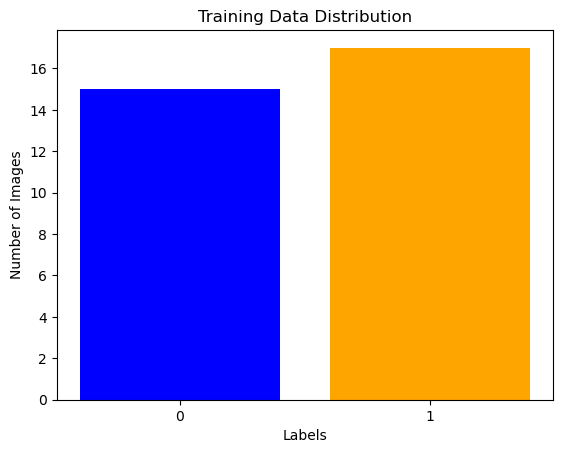

In [8]:
# Define label2id mapping
label2id = {0.0: 0, 1.0: 1}
id2label = {0.0: "0", 1.0: "1"}
# Count the occurrences of each label
unique, counts = np.unique(train_labels, return_counts=True)

# Plot the distribution
plt.bar([id2label[label] for label in unique], counts, color=['blue', 'orange'])
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Training Data Distribution')
plt.show()

In [9]:
# Convert train and validation data into a format compatible with DataLoader
train_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(train_images, train_labels)]
val_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(val_images, val_labels)]

# Define collate function
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Create DataLoaders
train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
val_dataloader = DataLoader(val_data, collate_fn=collate_fn, batch_size=4)

In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [11]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Model loading + Hyperparameter tuning

In [12]:
# Load the model with the corrected mappings
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:

metric_name = "accuracy"

args = TrainingArguments(
    "checkpoints",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5, #0.00002
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

# Running and model evaluation

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.639480,0.740741
2,No log,0.628635,0.777778
3,No log,0.622434,0.777778
4,No log,0.618256,0.777778
5,No log,0.616016,0.777778


TrainOutput(global_step=5, training_loss=0.5196756362915039, metrics={'train_runtime': 81.0609, 'train_samples_per_second': 1.974, 'train_steps_per_second': 0.062, 'total_flos': 1.239871833833472e+16, 'train_loss': 0.5196756362915039, 'epoch': 5.0})

In [27]:
test_dir = os.path.join(DATA_DIR, 'test')

test_datagen = ImageDataGenerator(rescale=1./255)


# Load and label the validation dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 27 images belonging to 2 classes.


In [28]:
test_images, test_labels = apply_transforms(test_generator, val_transforms)

test_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(test_images, test_labels)]

In [29]:
outputs = trainer.predict(test_data)

In [30]:
print(outputs.metrics)

{'test_loss': 0.6578773260116577, 'test_accuracy': 0.6296296296296297, 'test_runtime': 3.4286, 'test_samples_per_second': 7.875, 'test_steps_per_second': 2.042}


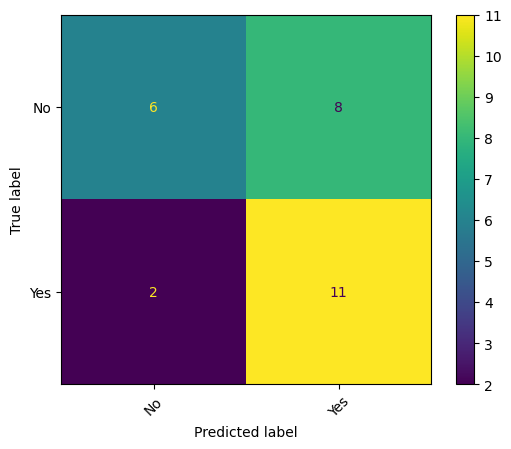

In [31]:
labels = ["No", "Yes"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)